### Summary

This dataset (olx-jobs) is published by Grupa OLX sp. z o.o. and contains 65 502 201 events made on http://olx.pl/praca by 3 295 942 users who interacted with 185 395 job ads in 2 weeks of 2020.


#### INTERACTIONS FILE DESCRIPTION
================================================================================


The file interactions.csv consists of 65 502 201 rows. 
Each row represents an interaction between a user and an item and has the following format:
user, item, event, timestamp.

* user: a numeric id representing the user who made the interaction
* item: a numeric id representing the item the user interacted with
* event: a type of interaction between the user and the item, possible values are:
	- click: the user visited the item detail page
	- bookmark: the user added the item to bookmarks
	- chat_click: the user opened the chat to contact the itemâ€™s owner
	- contact_phone_click_1: the user revealed the phone number attached to the item
	- contact_phone_click_2: the user clicked to make a phone call to the itemâ€™s owner
	- contact_phone_click_3: the user clicked to send an SMS to the itemâ€™s owner
	- contact_partner_click: the user clicked to access the itemâ€™s owner external page
	- contact_chat: the user sent a message to the itemâ€™s owner
* timestamp: the Unix timestamp of the interaction


## Note: <br>


<b>
I am sampling the data of 1000 users instead of using entire dataset. My primary focus on this case study is to follow the approach to build a personalized recommendation rather than providing best solution. And also my laptop configuration is not sufficient to train the entire dataset </b>

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import math

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#### Interactions csv contains information about users who interacted with jobs from February 12th 2020 to February 25th 2020

In [2]:
df = pd.read_csv('interactions.csv')
df['datetime'] = pd.to_datetime(df.timestamp, unit='s')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65502201 entries, 0 to 65502200
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   user       int64         
 1   item       int64         
 2   event      object        
 3   timestamp  int64         
 4   datetime   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.4+ GB


In [4]:
print("There are {} Users , {} items and {} interactions".format(df.user.nunique(),
                                                                 df.item.nunique(),
                                                                 df.shape[0]))


print("Average interactions per user ",df.groupby(['user']).size().mean())
      
print("Average interactions per item ", df.groupby(['item']).size().mean())



There are 3295942 Users , 185395 items and 65502201 interactions
Average interactions per user  19.87359031196544
Average interactions per item  353.31158337603495


In [5]:
df.datetime.min(), df.datetime.min()

(Timestamp('2020-02-12 00:00:00'), Timestamp('2020-02-12 00:00:00'))

#### Events Distribution

In [6]:
df.event.value_counts(normalize=True)

click                    0.897943
contact_phone_click_1    0.026279
bookmark                 0.025108
chat_click               0.021359
contact_chat             0.014480
contact_partner_click    0.007012
contact_phone_click_2    0.006786
contact_phone_click_3    0.001033
Name: event, dtype: float64

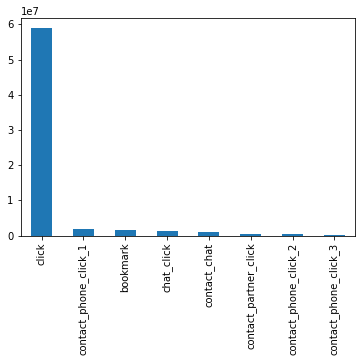

In [7]:
df.event.value_counts().plot(kind='bar');

### Data preparation

As there are different interactions types, we associate them with a weight or strength, assuming that, for example, a contact indicates a higher interest of the user on the job ads than a simple click.

Sampling 1000 random users

In [8]:
df = df[df.user.isin(random.sample(df.user.values.tolist(), 1000))]

These are the random weights assigned to the each event type this can be changed after getting better understanding of the event types in real time

In [9]:
# Interaction strength
user_weights = {
 'click':1.0,
 'bookmark':2.0,
 'chat_click':3.0,
 'contact_phone_click_1':3.0, 
 'contact_phone_click_2':4.0, 
 'contact_phone_click_3':5.0,
 'contact_partner_click':6.0,
 'contact_chat':7.0
}   

In [10]:
df['rating'] = df['event'].map(user_weights)

In [11]:
df

,user,item,event,timestamp,datetime,rating
1407,2831405,83609,click,1581465632,2020-02-12 00:00:32,1.0
2161,2752034,133478,click,1581465649,2020-02-12 00:00:49,1.0
2673,735926,31089,click,1581465662,2020-02-12 00:01:02,1.0
4950,1167905,173483,click,1581465716,2020-02-12 00:01:56,1.0
5027,735926,13018,click,1581465718,2020-02-12 00:01:58,1.0
...,...,...,...,...,...,...
65500060,1804482,126731,click,1582675147,2020-02-25 23:59:07,1.0
65501282,629392,46560,click,1582675177,2020-02-25 23:59:37,1.0
65501300,1804482,173941,click,1582675177,2020-02-25 23:59:37,1.0
65501598,1804482,126731,click,1582675185,2020-02-25 23:59:45,1.0


As users are allowed to click on many job ads, and interact with them in different ways (eg. click or contact ). Thus, to model the user interest on a given job ad, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

And,Also splitting the data into train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date.

In [12]:
def normalize_distribution(x):
    return math.log(1+x, 2)


df_train = df[df.datetime<'2020-02-22']
df_test = df[df.datetime>='2020-02-22']

df_train_final = df_train.groupby(['user', 'item'])['rating'].sum().apply(normalize_distribution).reset_index()
df_test_final = df_test.groupby(['user', 'item'])['rating'].sum().apply(normalize_distribution).reset_index()

#### Collaborative Filtering

Matrix Factorization

Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.

In [13]:
user_item_matrix = df_train_final.pivot(index='user', columns='item', values='rating').fillna(0)

In [14]:
user_item_matrix

item,1,6,9,10,12,13,15,20,24,27,...,185311,185317,185326,185329,185333,185365,185367,185369,185377,185385
user,,,,,,,,,,,,,,,,,,,,,
3036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3288251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3288411,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
user_item_sparse_matrix = csr_matrix(user_item_matrix)

In [16]:
user_item_sparse_matrix

<924x38218 sparse matrix of type '<class 'numpy.float64'>'
	with 63724 stored elements in Compressed Sparse Row format>

Performs matrix factorization of the original user item matrix

In [17]:
U, sigma, Vt = svds(user_item_sparse_matrix, k = 15)

In [18]:
U

array([[ 2.36065287e-05, -3.51494412e-06,  1.60810950e-05, ...,
         6.65483205e-05, -4.34010752e-05, -6.13826452e-06],
       [-2.21892655e-04, -1.77715637e-04,  6.67965331e-05, ...,
         8.26773140e-05, -7.11382650e-05, -3.99894267e-04],
       [-1.23380634e-04, -3.06576109e-04,  1.66273137e-03, ...,
         1.26107965e-04, -1.82349677e-03, -1.57799684e-04],
       ...,
       [-2.68801196e-07, -1.44839497e-03,  2.76425352e-04, ...,
         1.33361337e-02, -1.16864645e-03, -2.31744178e-04],
       [ 3.40408036e-04, -3.02795477e-04,  4.13918040e-04, ...,
         3.64018075e-04, -7.67183358e-04, -1.40039865e-04],
       [-1.14658670e-03, -3.09406268e-04, -2.91809313e-05, ...,
         5.64936568e-04, -6.90919183e-04, -9.83990025e-05]])

In [19]:
sigma =  np.diag(sigma)
sigma

array([[35.24322122,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 35.77788464,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 36.44633219,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 37.2815994 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 38.45548544,
         0.        ,  0.        ,  0.        , 

In [20]:
Vt

array([[-7.07192611e-05,  1.57757462e-06,  1.15923214e-04, ...,
        -3.89102666e-05,  3.76611396e-06,  3.67175960e-04],
       [-4.54285895e-05,  1.81251485e-08, -9.19229343e-05, ...,
        -1.20220749e-04,  1.42009361e-07,  2.07264968e-04],
       [ 1.32082906e-05,  4.61786548e-06,  5.88783349e-05, ...,
         8.38798346e-05,  5.62241369e-05,  6.28686160e-04],
       ...,
       [ 3.74308889e-06,  1.37517825e-06,  1.46161354e-04, ...,
         9.53178440e-05,  2.30412124e-05,  5.18760307e-04],
       [-2.79833321e-05, -1.49747003e-06, -4.58779123e-05, ...,
        -1.17706209e-04, -5.44669980e-05, -6.52972483e-04],
       [-5.58202109e-05, -2.80969928e-07, -2.14681088e-05, ...,
        -1.16458639e-05, -5.41758417e-06, -2.92410588e-04]])

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction.

In [21]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
predicted_ratings

array([[6.77392467e-07, 9.18694612e-08, 1.90246205e-06, ...,
        6.08787481e-06, 1.73351189e-06, 1.83497135e-05],
       [2.68546825e-06, 1.27510372e-07, 3.01651939e-06, ...,
        5.97745550e-06, 1.96828620e-06, 8.31980456e-05],
       [8.38791946e-06, 1.62507498e-06, 4.24953722e-05, ...,
        5.39464131e-05, 1.80323053e-05, 1.21486555e-03],
       ...,
       [6.40576488e-06, 5.78185550e-07, 7.98023991e-05, ...,
        5.75305320e-05, 1.12308239e-05, 9.41109747e-05],
       [7.72581499e-06, 1.12733289e-06, 2.75337198e-05, ...,
        6.95361012e-05, 2.23140249e-05, 5.62471734e-04],
       [9.94471958e-06, 9.21094782e-07, 2.48411621e-05, ...,
        5.16045744e-05, 2.26357477e-05, 5.92594463e-04]])

#### Normalize the predicted ratings

In [22]:
predicted_ratings_norm = (predicted_ratings - predicted_ratings.min()) / (predicted_ratings.max() - predicted_ratings.min())

users_ids = list(user_item_matrix.index)

In [23]:
#Converting the reconstructed matrix back to a Pandas dataframe
predictions_df = pd.DataFrame(predicted_ratings_norm, columns = user_item_matrix.columns, index=users_ids).transpose()
predictions_df.head(10)

,3036,7268,12585,16405,17634,19833,20992,28166,29507,30358,...,3262556,3263865,3265510,3271646,3272821,3276696,3288251,3288411,3290622,3293057
item,,,,,,,,,,,,,,,,,,,,,
1,0.102072,0.102072,0.102073,0.102072,0.102101,0.102072,0.102097,0.102076,0.102075,0.102072,...,0.102072,0.102075,0.102073,0.102072,0.102073,0.102072,0.102072,0.102072,0.102073,0.102073
6,0.102072,0.102072,0.102072,0.102072,0.102073,0.102072,0.102074,0.102072,0.102072,0.102072,...,0.102072,0.102072,0.102072,0.102072,0.102072,0.102072,0.102072,0.102072,0.102072,0.102072
9,0.102072,0.102072,0.102077,0.102072,0.102117,0.102081,0.102141,0.102073,0.102087,0.102072,...,0.102074,0.102075,0.102076,0.102074,0.102073,0.102072,0.102076,0.102082,0.102075,0.102075
10,0.102072,0.102073,0.102079,0.102072,0.102158,0.102074,0.102126,0.102072,0.102103,0.102073,...,0.102078,0.102086,0.102076,0.102072,0.102092,0.102072,0.102070,0.102072,0.102090,0.102088
12,0.102072,0.102072,0.102072,0.102072,0.102110,0.102075,0.102077,0.102072,0.102073,0.102072,...,0.102072,0.102072,0.102074,0.102072,0.102072,0.102072,0.102072,0.102076,0.102072,0.102072
13,0.102072,0.102072,0.102072,0.102072,0.102080,0.102073,0.102078,0.102072,0.102072,0.102072,...,0.102072,0.102072,0.102072,0.102072,0.102072,0.102072,0.102073,0.102073,0.102072,0.102072
15,0.102073,0.102073,0.102076,0.102074,0.102225,0.102081,0.102735,0.102073,0.102086,0.102075,...,0.102083,0.102086,0.102087,0.102072,0.102079,0.102072,0.102073,0.102083,0.102085,0.102083
20,0.102072,0.102073,0.102077,0.102072,0.102158,0.102077,0.102138,0.102078,0.102082,0.102072,...,0.102074,0.102079,0.102079,0.102076,0.102076,0.102072,0.102079,0.102080,0.102076,0.102076
24,0.102073,0.102072,0.102074,0.102073,0.102171,0.102078,0.102461,0.102071,0.102077,0.102074,...,0.102078,0.102079,0.102081,0.102072,0.102072,0.102072,0.102071,0.102079,0.102079,0.102077


### Recommendations

In [24]:
def get_items_interacted(user_id, interactions_df):
    '''
    This function returns the interacted items based on user 
    '''
    interacted_items = interactions_df.loc[user_id]['item']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])



def get_recommendations(predictions_df, user_id, df_train, topn=1000):
    
    '''
    This function returns the topn recommendations to the user
        if the user is present during training then returns the recommendations based SVD reconstruced matrix
        else user gets the highest viewed job ads in the entire training dataset (this is to address cold start problem)
    '''
    if user_id in predictions_df.columns:
    
        # Get and sort the user's predictions
        sorted_user_predictions = predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'prediction'})

        # Recommend the highest predicted rating jobs that the user hasn't seen yet.

        interacted_items = get_items_interacted(user_id, df_train.set_index('user'))
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['item'].isin(interacted_items)] \
                                   .sort_values('prediction', ascending = False) \
                                   .head(topn)
    else:
        print("Recommending Popular job ads")
        recommendations_df = df_train_final.groupby('item')['rating'].sum().sort_values(ascending=False).reset_index().rename(columns={'rating': 'prediction'}).head(topn)
        
    return recommendations_df

### Evaluation of recommender system

In [25]:
def get_not_interacted_items_sample(user_id, sample_size, seed=42):
    '''
    This function returns the items which user not has seen before 
    '''
    interacted_items = get_items_interacted(user_id, df_train.set_index('user'))
    all_items = set(df['item'])
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return set(non_interacted_items_sample)


def check_top_n(item_id, recommended_items, topn): 
    '''
    This function checks and returns the top n relevant items which are present in the recommended items
    '''
    try:
        index = next(i for i, c in enumerate(recommended_items) if c == item_id)
    except:
        index = -1
    hit = int(index in range(0, topn))
    return hit, index

In [26]:
interactions_test_indexed_df = df_test_final.set_index('user')

In [27]:
def evaluate_model_for_user(user_id):
    '''
    This function evaulates the model performance for each user and return the metrics
    '''
    #Getting the items in test set
    interacted_values_testset = interactions_test_indexed_df.loc[user_id]
    if type(interacted_values_testset['item']) == pd.Series:
        user_interacted_items_testset = set(interacted_values_testset['item'])
    else:
        user_interacted_items_testset = set([int(interacted_values_testset['item'])])  
    interacted_items_count_testset = len(user_interacted_items_testset) 
    
    ## Getting recommendations
    user_recs_df = get_recommendations(predictions_df, user_id, df_train)

    hits_at_5_count = 0
    hits_at_10_count = 0
    top_10_relevant_items_count = 0
    valid_recs_count = 0
    for item_id in user_interacted_items_testset:
        non_interacted_items_sample = get_not_interacted_items_sample(user_id,
                                                                      sample_size=100, 
                                                                      seed=item_id%(2**32))

        #Combining the current interacted item with the 100 random items
        items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
        #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
        valid_recs_df = user_recs_df[user_recs_df['item'].isin(items_to_filter_recs)]  
        valid_recs = valid_recs_df['item'].values
        
        top_relevant_hit, index_at_10 = check_top_n(item_id, valid_recs, 10)
        top_10_relevant_items_count += top_relevant_hit
        valid_recs_count += len(valid_recs)
    
    if len(valid_recs)>0:
        precision_at_10 = top_10_relevant_items_count/valid_recs_count
    else:
        precision_at_10 = 0
        
    user_metrics = {'top@10_count': top_10_relevant_items_count, 
                        'interacted_count': interacted_items_count_testset,
                        'precision@10':precision_at_10,
                        'recommedation_count':len(valid_recs)}
    return user_metrics

In [28]:
def evaluate_model():
    '''
    This function evaulates the model performance and returns the metrics
    '''
    #print('Running evaluation for users')
    users_metrics = []
    for idx, user_id in enumerate(list(interactions_test_indexed_df.index.unique().values[:10])):
        if user_id in df_train.user.unique():
            user_metrics = evaluate_model_for_user(user_id)  
            user_metrics['_user_id'] = user_id
            users_metrics.append(user_metrics)
        print('%d users processed' % (idx+1))

    results_df = pd.DataFrame(users_metrics) \
                        .sort_values('interacted_count', ascending=False)

    precision_at_10 = results_df['top@10_count'].sum() / float(results_df['recommedation_count'].sum())

    metrics = {'precision@10':precision_at_10}  
    
    return metrics, results_df

### Metrics

In [29]:
metrics, results_df  = evaluate_model()

1 users processed
2 users processed
3 users processed
4 users processed
5 users processed
6 users processed
7 users processed
8 users processed
9 users processed
10 users processed


In [30]:
print('\nMetrics:\n%s' % metrics)
results_df.head(10)


Metrics:
{'precision@10': 1.173913043478261}


,top@10_count,interacted_count,precision@10,recommedation_count,_user_id
1,1,171,0.002494,2,12585
6,13,153,0.041401,4,36952
2,1,62,0.007634,3,17634
7,11,58,0.086614,2,55559
4,0,45,0.000000,1,29507
3,0,24,0.000000,2,19833
5,1,22,0.022222,5,33796
8,0,11,0.000000,2,56589
0,0,7,0.000000,2,3036


### Conclusion


I have explored the collaborative recommender system in this notebook. 
    
    
<b>How do you deal with users with no events prior to the 4 days used for testing?</b>

I am calculating evaulation metric only for the users whose data is present in the training data and dropping all the users whose events not present in the training dataset 

This is basically a cold start problem:
a new visitor has no interactions, so collaborative filtering is of no use for recommendation. Only after we have some feedback we can begin to work with that. 

+ How to solve :
    - Content Based Filtering
	- Show most popular items
	- Association rules 
	- Segmentation



<b>How important is each type of event to your model? why? Can you think of a way to determine such importance using data?</b>

+ The standard approach to matrix factorization based collaborative filtering treats the entries in the user-item matrix as explicit preferences given by the user to the item, for example, users giving ratings to movies.

+ In this use case only have access to implicit feedback (e.g. views, bookmarks, contacts,etc.). Essentially, instead of trying to model the matrix of ratings directly, this approach treats the data as numbers representing the strength in observations of user actions Those numbers are then related to the level of confidence in observed user preferences, rather than explicit ratings given to items. The model then tries to find latent factors that can be used to predict the expected preference of a user for an item.

These are the random weights assigned to the each event type this can be changed after getting better understanding of the event types in real time

 + click:1.0
 + bookmark:2.0
 + chat_click:3.0
 + contact_phone_click_1:3.0
 + contact_phone_click_2:4.0
 + contact_phone_click_3:5.0
 + contact_partner_click:6.0
 + contact_chat:7.0
  


<b>Think and present how would you put such system into production serving million of users per day</b>
<img src ='/architecture.png'>

<b>Think and present how the development cycle of such system would be</b>
<img src ='/MLPipeline.png'>
